# Project 1: Banana Collector

---

In this notebook, I am going to implement the banana collector agent of the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). 

This notebook includes a comparison between different additional improvements for DQN. We compare following appoaches:
* DQN
* DQN with Double DQN
* DQN with prioritized experience replay
* DQN with Double DQN and prioritized experience replay

After each approach, the neural network models (as well as the replay buffer), will be saved to disk. You can use notebook [banana-collector-play](./banana-collector-play.ipynb) to load the neural network models and to see you agent in action.

## 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from modules.agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded. You can decide between headless and visual option. However, the headless option is a lot faster and at the end, the weights of the neural network will be stored to disk. You can use the trained weights in notebook [banana-collector-play](./banana-collector-play.ipynb), there we will just run the agent in a visual environment and you can see your agent in action.

- **Linux** (x86_64): `"./Banana_Linux/Banana.x86_64"`
- **Linux** (x86_64, headless): `"./Banana_Linux_NoVis/Banana.x86_64"`

In [2]:
# env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

numberOfActions = action_size
numberOfStates = state_size

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 3. Define the main dqn function and some helper functions

In [5]:
def dqn(agent, n_episodes, eps_start, eps_end, eps_decay):
    environment_solved = False
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score

        while True:
            action = agent.act(state, eps)        # select an action

            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) > 13.0 and environment_solved == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            environment_solved = True
            # break
            
    return scores

def printPlot(title, scores, movingAverage=100):
    # plot the scores
    fig = plt.figure(1, figsize=(12, 12))
    
    mvgAvg = []
    scores_window = deque(maxlen=movingAverage)
    for s1 in scores:
        scores_window.append(s1)
        mvgAvg.append(np.mean(scores_window))    
    
    ax1 = fig.add_subplot(1,1,1)
    plt.plot(np.arange(len(scores)), scores, np.arange(len(scores)), mvgAvg)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    
    plt.show()
    

def printPlotAll(title, scores1, scores2, scores3, scores4, movingAverage=100):
    # plot the scores
    fig = plt.figure(1, figsize=(12, 12))
    
    mvgAvg1 = []
    mvgAvg2 = []
    mvgAvg3 = []
    mvgAvg4 = []
    scores_window1 = deque(maxlen=movingAverage)
    scores_window2 = deque(maxlen=movingAverage)
    scores_window3 = deque(maxlen=movingAverage)
    scores_window4 = deque(maxlen=movingAverage)
    for s1, s2, s3, s4 in zip(scores1[0], scores2[0], scores3[0], scores4[0]):
        scores_window1.append(s1)
        mvgAvg1.append(np.mean(scores_window1))
        
        scores_window2.append(s2)
        mvgAvg2.append(np.mean(scores_window2))
        
        scores_window3.append(s3)
        mvgAvg3.append(np.mean(scores_window3))
        
        scores_window4.append(s4)
        mvgAvg4.append(np.mean(scores_window4))
    
    red_patch = mpatches.Patch(color='red', label=scores1[1])
    blue_patch = mpatches.Patch(color='blue', label=scores2[1])
    green_patch = mpatches.Patch(color='green', label=scores3[1])
    yellow_patch = mpatches.Patch(color='orange', label=scores4[1])
    
    episodes = np.arange(len(scores1[0]))
    ax1 = fig.add_subplot(1,1,1)
    plt.plot(episodes, mvgAvg1, 'red', episodes, mvgAvg2, 'blue', episodes, mvgAvg3, 'green', episodes, mvgAvg4, 'orange')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])
    
    plt.show()
    
    
def writeScoreToFile(filename, scores):
    file = open("./models/" + filename, "w") 
 
    for score in scores:
        file.write(str(score) + "\n")
        
    file.close()

## 4. Run different approaches

In [6]:
REPLAY_BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
LEARNING_RATE = 5e-4
UPDATE_EVERY = 13
GAMMA = 0.99
TAU = 1e-3

SEED = 0

n_episodes = 2000    # n_episodes (int): maximum number of training episodes
eps_start = 1.0      # eps_start (float): starting value of epsilon, for epsilon-greedy action selection
eps_end = 0.0001     # eps_end (float): minimum value of epsilon
eps_decay = 0.99     # eps_decay (float): multiplicative factor (per episode) for decreasing epsilon

myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 4.1 DQN Plain

In [7]:
ACTIVATE_DDQN = False
ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY = False

agent = Agent.for_training(
            state_size=numberOfStates, 
            action_size=numberOfActions,
              
            activate_ddqn=ACTIVATE_DDQN,
            activate_prioritized_experience_replay=ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY,
              
            replay_buffer_size=REPLAY_BUFFER_SIZE,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            update_every=UPDATE_EVERY,
            gamma=GAMMA,
            tau=TAU,
              
            seed=SEED,
            device=myDevice)

scores_dqn_plain = dqn(agent, n_episodes, eps_start, eps_end, eps_decay)
agent.save("./models/dqn_plain_")

cuda:0
Episode 100	Average Score: 1.61
Episode 200	Average Score: 8.01
Episode 300	Average Score: 10.72
Episode 400	Average Score: 12.30
Episode 500	Average Score: 12.17
Episode 526	Average Score: 13.02
Environment solved in 426 episodes!	Average Score: 13.02
Episode 600	Average Score: 15.02
Episode 700	Average Score: 13.80
Episode 800	Average Score: 13.40
Episode 900	Average Score: 13.53
Episode 1000	Average Score: 14.71
Episode 1100	Average Score: 15.58
Episode 1200	Average Score: 14.26
Episode 1300	Average Score: 15.01
Episode 1400	Average Score: 15.54
Episode 1500	Average Score: 15.97
Episode 1600	Average Score: 16.51
Episode 1700	Average Score: 15.89
Episode 1800	Average Score: 16.51
Episode 1900	Average Score: 16.61
Episode 2000	Average Score: 16.66


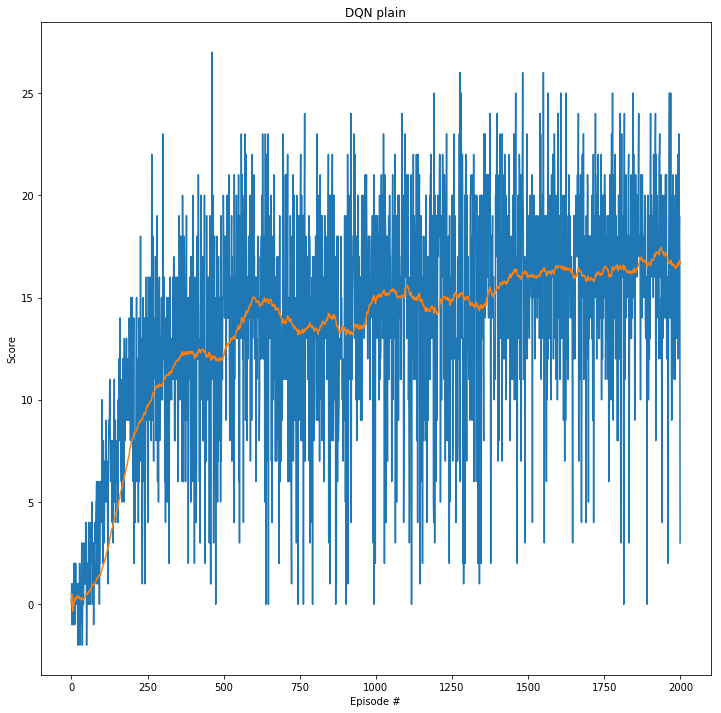

In [8]:
# plot the scores
printPlot("DQN plain", scores_dqn_plain, 100)
writeScoreToFile("dqn_plain_scores.txt", scores_dqn_plain)

## 4.2 DQN with Double DQN

In [10]:
ACTIVATE_DDQN = True
ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY = False

agent = Agent.for_training(
            state_size=numberOfStates, 
            action_size=numberOfActions,
              
            activate_ddqn=ACTIVATE_DDQN,
            activate_prioritized_experience_replay=ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY,
              
            replay_buffer_size=REPLAY_BUFFER_SIZE,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            update_every=UPDATE_EVERY,
            gamma=GAMMA,
            tau=TAU,
              
            seed=SEED,
            device=myDevice)

scores_double_dqn = dqn(agent, n_episodes, eps_start, eps_end, eps_decay)
agent.save("./models/dqn_ddqn_")

cuda:0
Episode 100	Average Score: 1.07
Episode 200	Average Score: 7.95
Episode 300	Average Score: 10.93
Episode 400	Average Score: 11.48
Episode 500	Average Score: 10.47
Episode 600	Average Score: 11.88
Episode 657	Average Score: 13.03
Environment solved in 557 episodes!	Average Score: 13.03
Episode 700	Average Score: 13.21
Episode 800	Average Score: 13.71
Episode 900	Average Score: 15.27
Episode 1000	Average Score: 15.46
Episode 1100	Average Score: 15.43
Episode 1200	Average Score: 14.40
Episode 1300	Average Score: 15.88
Episode 1400	Average Score: 15.33
Episode 1500	Average Score: 16.52
Episode 1600	Average Score: 15.90
Episode 1700	Average Score: 16.44
Episode 1800	Average Score: 16.23
Episode 1900	Average Score: 16.08
Episode 2000	Average Score: 15.37


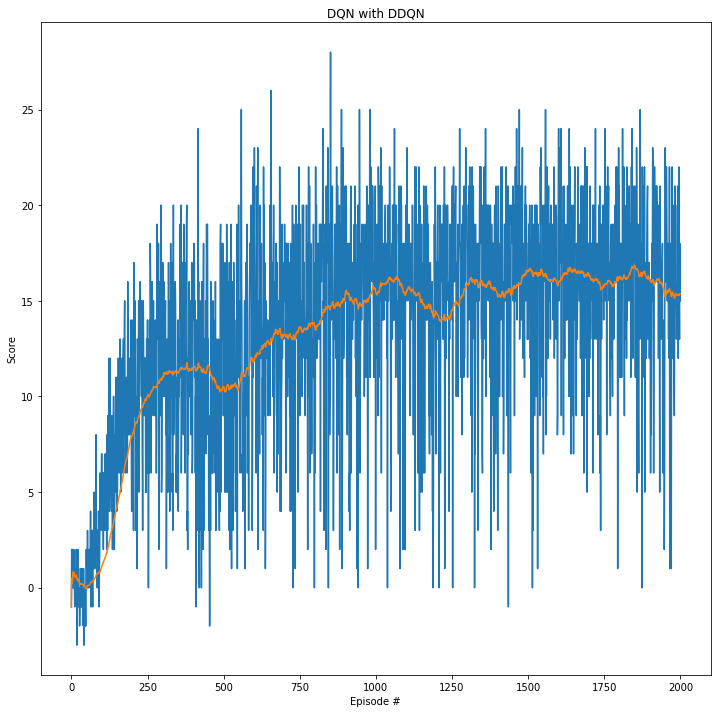

In [129]:
# plot the scores
printPlot("DQN with DDQN", scores_double_dqn, 100)
writeScoreToFile("dqn_ddqn_scores.txt", scores_double_dqn)

## 4.3 DQN with PER (prioritized experience replay)

In [12]:
ACTIVATE_DDQN = False
ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY = True

agent = Agent.for_training(
            state_size=numberOfStates, 
            action_size=numberOfActions,
              
            activate_ddqn=ACTIVATE_DDQN,
            activate_prioritized_experience_replay=ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY,
              
            replay_buffer_size=REPLAY_BUFFER_SIZE,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            update_every=UPDATE_EVERY,
            gamma=GAMMA,
            tau=TAU,
              
            seed=SEED,
            device=myDevice)

scores_per = dqn(agent, n_episodes, eps_start, eps_end, eps_decay)
agent.save("./models/dqn_per_")

cuda:0
Episode 100	Average Score: 1.91
Episode 200	Average Score: 7.56
Episode 300	Average Score: 10.44
Episode 400	Average Score: 9.206
Episode 500	Average Score: 10.96
Episode 600	Average Score: 12.31
Episode 700	Average Score: 12.80
Episode 712	Average Score: 13.07
Environment solved in 612 episodes!	Average Score: 13.07
Episode 800	Average Score: 14.94
Episode 900	Average Score: 14.85
Episode 1000	Average Score: 16.53
Episode 1100	Average Score: 15.53
Episode 1200	Average Score: 15.57
Episode 1300	Average Score: 16.63
Episode 1400	Average Score: 16.29
Episode 1500	Average Score: 15.58
Episode 1600	Average Score: 15.68
Episode 1700	Average Score: 16.12
Episode 1800	Average Score: 16.55
Episode 1900	Average Score: 16.20
Episode 2000	Average Score: 15.93


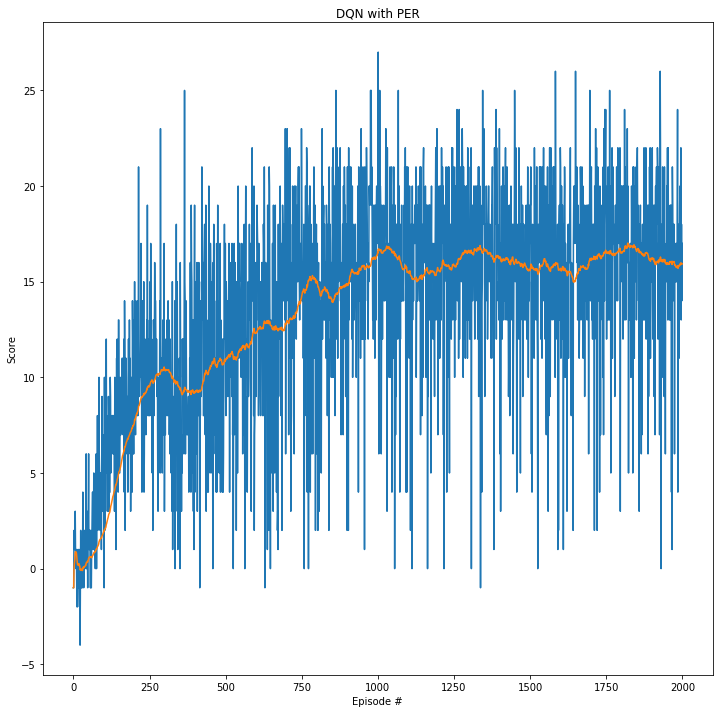

In [130]:
# plot the scores
printPlot("DQN with PER", scores_per, 100)
writeScoreToFile("dqn_per_scores.txt", scores_per)

## 4.4 DQN with DDQN and PER

In [14]:
ACTIVATE_DDQN = True
ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY = True

agent = Agent.for_training(
            state_size=numberOfStates, 
            action_size=numberOfActions,
              
            activate_ddqn=ACTIVATE_DDQN,
            activate_prioritized_experience_replay=ACTIVATE_PRIORITIZED_EXPERIENCE_REPLAY,
              
            replay_buffer_size=REPLAY_BUFFER_SIZE,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            update_every=UPDATE_EVERY,
            gamma=GAMMA,
            tau=TAU,
              
            seed=SEED,
            device=myDevice)

scores_ddqn_per = dqn(agent, n_episodes, eps_start, eps_end, eps_decay)
agent.save("./models/dqn_ddqn_per_")

cuda:0
Episode 100	Average Score: 1.10
Episode 200	Average Score: 6.98
Episode 300	Average Score: 10.00
Episode 400	Average Score: 11.10
Episode 488	Average Score: 13.07
Environment solved in 388 episodes!	Average Score: 13.07
Episode 500	Average Score: 12.83
Episode 600	Average Score: 11.68
Episode 700	Average Score: 13.38
Episode 800	Average Score: 13.15
Episode 900	Average Score: 14.83
Episode 1000	Average Score: 14.16
Episode 1100	Average Score: 16.79
Episode 1200	Average Score: 16.05
Episode 1300	Average Score: 16.89
Episode 1400	Average Score: 16.42
Episode 1500	Average Score: 16.04
Episode 1600	Average Score: 16.48
Episode 1700	Average Score: 15.33
Episode 1800	Average Score: 15.86
Episode 1900	Average Score: 15.66
Episode 2000	Average Score: 15.79


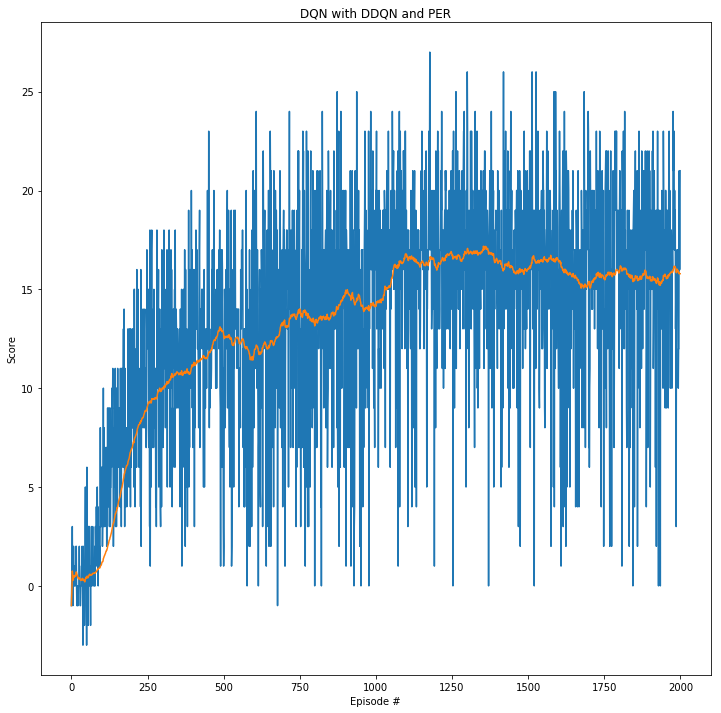

In [131]:
# plot the scores
printPlot("DQN with DDQN and PER", scores_ddqn_per, 100)
writeScoreToFile("dqn_ddqn_per_scores.txt", scores_ddqn_per)

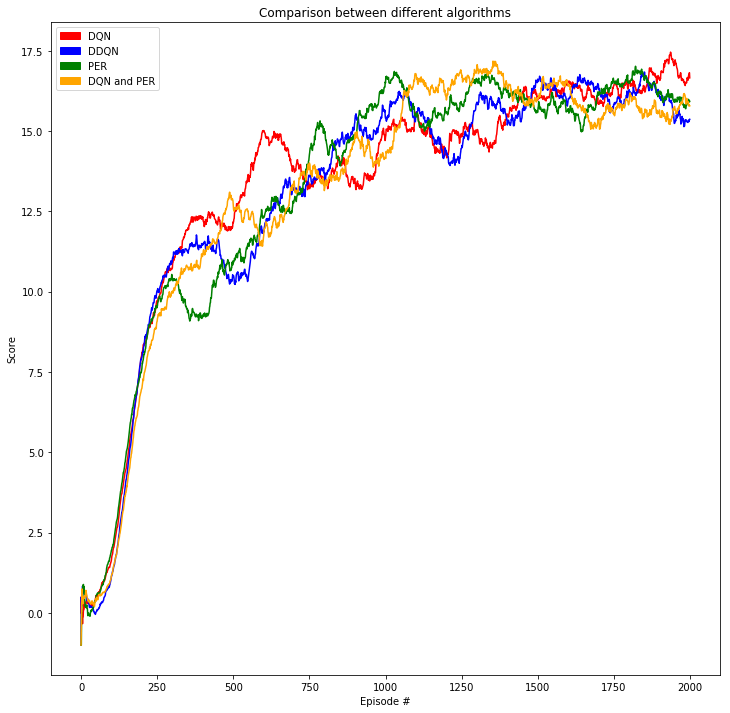

In [133]:
printPlotAll("Comparison between different algorithms", (scores_dqn_plain, "DQN"), (scores_double_dqn, "DDQN"), (scores_per, "PER"), (scores_ddqn_per, "DQN and PER"), 100)

When finished, you can close the environment.

In [ ]:
env.close()